Da bismo radili sa bibliotekom `skfuzzy`, potrebno je da je instaliramo na sledeći način:

In [1]:
!pip install scikit-fuzzy

     |████████████████████████████████| 993 kB 4.1 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=97e603d95629eafd0728e74f63f4b42f3b8f17139af7c4f1dbabbb451a169916
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


Nakon importovanja biblioteka (`numpy`, `skfuzzy`), kreiraju se ulazne i izlazne promenljive, tj. fazi skupovi. Antecenenti (ulazne promenljive) će se nalaziti sa leve strane pravila, a konsekvent (izlazna promenljiva) sa desne strane. U ovom primeru antecedenti će biti hrana i usluga, na osnovu kojih želimo da odredimo napojnicu konobara (konsekvent).


Svi skupovi su na početku definisani kao univerzalni pomoću funkcije `np.arrange(start, end, step)` čiji su argumenti početak intervala vrednosti promenljive, kraj intervala i korak, tj. razlika između dve susedne vrednosti.

Koji način defazifikacije želimo, možemo da napišemo kao argument konsekventa (`defuzzify_method`), default-no je centroid, a ostale mogućnosti su - bisector, mom (mean of maximum), som (min of maximum), lom (max of maximum):

`napojnica = ctrl.Consequent(np.arange(0, 26, 1), 'napojnica', defuzzufy_method='bisector')`

In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

hrana = ctrl.Antecedent(np.arange(0, 11, 1), 'hrana')
usluga = ctrl.Antecedent(np.arange(0, 11, 1), 'usluga')
napojnica = ctrl.Consequent(np.arange(0, 26, 1), 'napojnica')
# napojnica = ctrl.Consequent(np.arange(0, 26, 1), 'napojnica', defuzzufy_method='bisector')


Lingvističke promenljive se mogu definisati na dva načina:


*   `input1.automf(names=['term1', 'term2', 'term3'])` bez definisanja intervala u okviru kog se nalaze elementi date lingvističke promenljive,

*   ```
    input1['term1'] = fuzz.trimf(input1.universe, [0, 0, 5])
    input1['term2'] = fuzz.gaussmf(input1.universe, 5, 1)
    input1['term3'] = fuzz.gaussmf(input1.universe, 10, 3)
    ```
    sa definisanim intervalom u okviru kog se nalaze elementi date lingvističke promenljive.

U primeru lingvističke promenljive za hranu su:


*   loša
*   srednje ukusna
*   veoma ukusna,

za uslugu:


*   loša
*   dobra
*   odlična,

i za napojnicu:



*   niska
*   srednja
*   visoka.

Za formiranje fazi skupova upotrebljeno je više vrsta funkcija pripadnosti: trougaona, trapezna, gausova, s, z...

Metoda koja je korišćena u primeru je Mamdanijeva metoda zaključivanja (Mamdani inference method).

In [3]:
hrana.automf(names=['losa', 'srednje ukusna', 'veoma ukusna'])

usluga['losa'] = fuzz.trimf(usluga.universe, [0, 0, 5])
usluga['dobra'] = fuzz.gaussmf(usluga.universe, 5, 2)
usluga['odlicna'] = fuzz.gaussmf(usluga.universe, 10, 3)
#usluga['izvanredna'] = fuzz.trapmf(usluga.universe, [1, 4, 6, 8])
#usluga['izvanredna'] = fuzz.smf(usluga.universe, 4, 6)
#usluga['izvanredna'] = fuzz.zmf(usluga.universe, 4, 6)
#usluga['izvanredna'] = fuzz.gbellmf(usluga.universe, 2, 3, 6)

napojnica['niska'] = fuzz.trimf(napojnica.universe, [0, 0, 13])
napojnica['srednja'] = fuzz.trapmf(napojnica.universe, [0, 13,15, 25])
napojnica['visoka'] = fuzz.trimf(napojnica.universe, [15, 25, 25])

# Grafički prikaz (vizuelizacija) kreiranih fazi skupova

Grafički prikaz fazi skupova dobija se pozivom funkcije view().

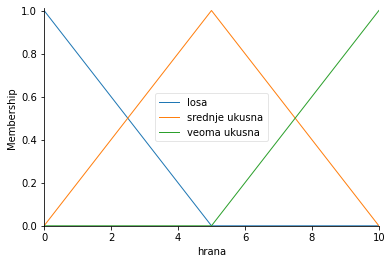

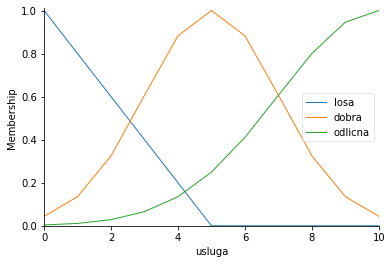

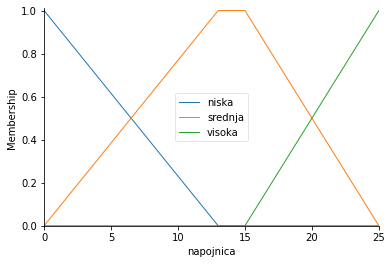

In [4]:
hrana.view()
usluga.view()
napojnica.view()

# Kreiranje pravila odlučivanja

Pravila se definišu na sledeći način, pomoću funkcije **Rule()** iz paketa **control**, koji je sastavni deo biblioteke **skfuzzy**. Prvi argument funkcije jeste ono što se nalazi sa leve strane pravila, a drugi argument ono što se nalazi sa desne strane pravila.

U primeru su definisana tri pravila:


1.   Ako usluga nije loša ili je hrana veoma ukusna, napojnica je visoka.
2.   Ako je usluga dobra, napojnica je srednja.
3.   Ako je usluga loša i hrana je loša, napojnica je niska.

In [5]:
rule1 = ctrl.Rule(~usluga['losa'] | hrana['veoma ukusna'], napojnica['visoka'])
rule2 = ctrl.Rule(usluga['dobra'], napojnica['srednja'])
rule3 = ctrl.Rule(usluga['losa'] & hrana['losa'], napojnica['niska'])

# Kreiranje i simulacija fazi kontrolera

Simulacijom fazi kontrolera se vrši proces zaključivanja.

Prvo se napravi kontroler (metoda `ControlSystem()`), koji kao argument prihvata listu pravila:

`napojnica_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])`.

Nakon toga se napravi simulator (metoda `ControlSystemSimulation()`) koji kao  argument prihvata kontroler.

Potrebno je uneti određene numeričke vrednosti za hranu i uslugu (```
napojnica_simulator.input['hrana'] = 9.5, napojnica_simulator.input['usluga'] = 9.4
```),

na osnovu kojih će se dobiti vrednost za konsekvent, tj.  napojnicu (`napojnica_simulator.compute()`). Taj proces se naziva defazifikacija.

In [6]:
napojnica_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
napojnica_simulator = ctrl.ControlSystemSimulation(napojnica_ctrl)

napojnica_simulator.input['hrana'] = 9.5
napojnica_simulator.input['usluga'] = 9.4

napojnica_simulator.compute()
print(napojnica_simulator.output['napojnica'])


18.581174375391615


# Grafički prikaz (vizuelizacija)  rezultata

Grafički prikaz rezultata zaključivanja dobija se metodom `view()`, koja kao argument prihvata napravljeni simulator.

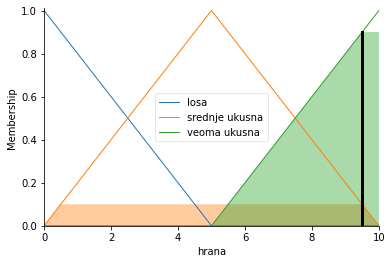

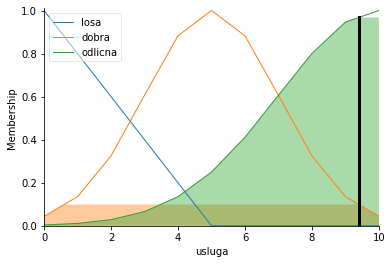

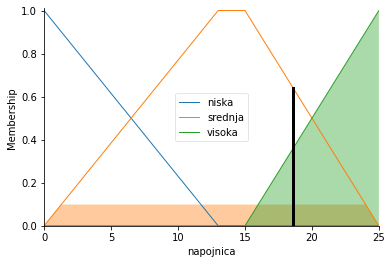

In [7]:
hrana.view(sim=napojnica_simulator)
usluga.view(sim=napojnica_simulator)
napojnica.view(sim=napojnica_simulator)